In [24]:
import sys
from abc import ABC, abstractmethod
import warnings
import numpy as np
from scipy import optimize
import matplotlib as mpl
from matplotlib import rcParams
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import multivariate_normal
import scanpy as scp
from sklearn.neighbors import NearestNeighbors
from sklearn.mixture import GaussianMixture
import random
import operator
import statsmodels.api as sm


import pandas as pd
import harmonypy as hm
from time import time
import seaborn as sns
import string

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min
from sklearn.preprocessing import StandardScaler
from econml.sklearn_extensions.linear_model import DebiasedLasso as dbl

from scipy.io import mmread
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
import umap.umap_ as umap
from itertools import permutations

import rpy2.rinterface_lib.callbacks
import logging

from rpy2.robjects.packages import importr
base = importr('base')
utils = importr('utils')
Matrix = importr('Matrix')
# seurat = importr('Seurat')
stats = importr('stats')

warnings.filterwarnings('ignore', category=DeprecationWarning) 

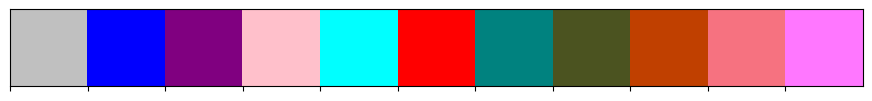

In [25]:
my_favourote_palette = ['#C0C0C0','#0000FF','#800080','#FFC0CB','#00FFFF','#FF0000','#00827F','#4B5320','#C04000','#F67280','#FF77FF']
sns.palplot(sns.color_palette(my_favourote_palette))
customPalette = sns.set_palette(sns.color_palette(my_favourote_palette))

### Utils Function

In this section we define the functions needed for pre-processing the data.

In [26]:
def machineEpsilon(func=float):
    machine_epsilon = func(1)
    while func(1)+func(machine_epsilon) != func(1):
        machine_epsilon_last = machine_epsilon
        machine_epsilon = func(machine_epsilon) / func(2)
    return machine_epsilon_last

In [27]:
# Creates a UMAP visualization of high dimensional data
## Input: Feature set, labels, colors of clusters
## Output: UMAP plot

def umap_visualize(arr, labels, palette="hls"):
    u = umap.UMAP().fit_transform(
        arr
    )
    umap_data = pd.DataFrame({'u0': u[:, 0], 'u1': u[:, 1], 'label': labels})
    sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette=palette)
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)

In [31]:
# Divides a row by its sum and sclaes it to a reference value
## Input: Frow to be sclaed, reference value
## Output: scaled row

def normalize_vector(v, scale_factor):
    return (v / np.sum(v)) * scale_factor

In [32]:
# Normalizes given cell by features matrix to remove sequencing depth irregularities
## Input: Matrix to be normalized and scaled
## Output: Normalized matrix

def normalize_data_matrix(A, scale_factor):
    A_temp = np.apply_along_axis(np.log1p, 1, A)
    A_temp = np.apply_along_axis(normalize_vector, 1, A_temp, scale_factor)  
    return A_temp

In [33]:
### Corrects Singular Values

def _convert_singular_val(y, gamma):
    t = (gamma * y ** 2 - (1 + gamma) + np.sqrt((gamma * y ** 2 - (1 + gamma)) ** 2 - 4 * gamma))/ (2 * gamma)
    return np.sqrt(t)

In [34]:
# Computes density of the square root of Marcenko Pastur Law

def sqrtmplaw(x, n_samples = 0, n_features = 0):
    '''we require the noise variance to be 1/n_samples
    '''
    aspect_ratio = n_features/n_samples
    lambda_plus = (1+np.sqrt(aspect_ratio))**2
    lambda_minus = (1 - np.sqrt(aspect_ratio))**2
    if x < lambda_minus or x > lambda_plus:
        return 0
    else: 
        return 1/(np.pi * aspect_ratio * x) * np.sqrt((lambda_plus - x)*(x - lambda_minus))

def sqrtMPlaw(arr, n, p):
    return [sqrtmplaw(x, n, p) for x in arr]

In [35]:
# Computes closest positive definite matrix to a given matrix

def nearPSD(A,epsilon=0):
   n = A.shape[0]
   eigval, eigvec = np.linalg.eig(A)
   val = np.matrix(np.maximum(eigval,1e-4))
   vec = np.matrix(eigvec)
   T = 1/(np.multiply(vec,vec) * val.T)
   T = np.matrix(np.sqrt(np.diag(np.array(T).reshape((n)) )))
   B = T * vec * np.diag(np.array(np.sqrt(val)).reshape((n)))
   out = B*B.T
   return(out)

In [36]:

def invreg(original_matrix, epsilon=1e-3):
    """
    Invert a matrix with regularization to avoid singularity.

    Parameters:
    - original_matrix: Input matrix to be inverted.
    - epsilon: Small value for regularization.

    Returns:
    - inverted_matrix: Inverted matrix.
    """

    # Adding a small diagonal matrix to avoid singularity
    diagonal_matrix = epsilon * np.eye(original_matrix.shape[0])
    regularized_matrix = original_matrix + diagonal_matrix

    # Invert the regularized matrix
    inverted_matrix = np.linalg.inv(regularized_matrix)

    return inverted_matrix

In [37]:
def replace_zeros_with_small_number(array, small_number=1e-30):
    """
    Replace zero values in a NumPy array with a very small number.

    Parameters:
    - array: NumPy array.
    - small_number: The small number to replace zero values with. Default is 1e-10.

    Returns:
    - Modified NumPy array with zero values replaced.
    """
    array[array == 0] = small_number
    return array

### OrchAMP functions for Atlas Building

The functions defined below are used to construct OrchAMP atlas from the training data using Algorithm 1 of the paper

In [38]:
def fit_gmm(data, n_components, M, D, seed):
    """
    Fits Gaussian Model defined in the paper using diagonal covariances.

    Parameters:
    - data: the dataset
    - n_components: number of clusters
    - M: A numpy array specifying the matrices S
    - D: A numpy array specify the matrices Sigma
    - seed: seed to intiate the algorithm

    Returns:
    - array of fitted means, covariances, and mixing proprtions
    """
    current_state = random.getstate()
    n_features = data.shape[1]
    inv_m = np.linalg.inv(M)
    gmm = GaussianMixture(n_components=n_components, random_state=seed)
    gmm.fit(data)
    means_unadjusted = gmm.means_
    means = means_unadjusted @ np.linalg.inv(M)
    adjusted_covariances = gmm.covariances_- D
    #covariances = np.array([nearPSD(inv_m @ cov @ inv_m.T) for cov in adjusted_covariances])
    traces = np.array([np.trace(cov_matrix) for cov_matrix in adjusted_covariances])
    positive_traces = np.maximum(traces, 0)
    adj_cov_factor = np.trace(M @ M.T)
    covariances_cons = positive_traces / adj_cov_factor
    covariances = np.array([cov * np.eye(n_features) for cov in covariances_cons])
    random.setstate(current_state)
    return means, covariances, gmm.weights_

In [39]:
def _get_W_gmm(data, m_prior, cov_prior, M, D, weights):

    """
    Posterior mixing proportions of the fitted gmm
    
    Parameters:
    - data: the dataset
    - m_prior: prior component means 
    - cov_prior: prior component covariances
    - M: The matrices 'S' mentioned in the paper 
    - D: The matrices 'Sigma' mentioned in the paper
    - weights: prior weights

    Returns:
    - posterior mixing proportions
    """


    num_components = len(weights)
    num_subjects = data.shape[0]
    responsibilities = np.zeros((num_components, num_subjects))
    
    # Convert the modality specific loadings to combined block diagonal matrices
    M_bd = sp.linalg.block_diag(*M)
    sigma_bd = sp.linalg.block_diag(*D)
    
    for components in range(num_components):
        mz = m_prior[components,:] @ M_bd.T
        matrix_to_cov = sigma_bd + M_bd @ cov_prior[components] @ M_bd.T
        covInv = np.linalg.inv(matrix_to_cov)
        
        fsq = (np.einsum("ik,ik -> i", data @ covInv, data) / 2)[:,np.newaxis]
        zsq = (mz.T @ covInv @ mz) / 2
        fz = np.array(data @ covInv @ mz)[:,np.newaxis]
        
        unscaled_weights = np.array(np.exp(np.clip(- fsq + fz - zsq,-700,700))).T
        del mz
         
        responsibilities[components,:] = weights[components] * unscaled_weights
    
    
    responsibilities = replace_zeros_with_small_number(responsibilities.T)
    
    total_responsibilities = np.log(np.sum(responsibilities, axis=1, keepdims = True))
    total_responsibilities[np.isneginf(total_responsibilities)] = -700
     
    responsibilities = np.log(responsibilities)
    responsibilities[np.isneginf(responsibilities)] = -700

    responsibilities = responsibilities - total_responsibilities
      
    return(np.exp(responsibilities))

In [40]:
def denoise_gmm(data, m_prior, cov_prior, M, D, weights): 

    """
    Denoise the updates using posterior mean from fitted gmm
    
    Parameters:
    - data: the dataset
    - m_prior: prior component means 
    - cov_prior: prior component covariances
    - M: The matrices 'S' mentioned in the paper 
    - D: The matrices 'Sigma' mentioned in the paper
    - weights: prior weights

    Returns:
    - denoised embeddings
    """
    
    num_components = len(weights)
    num_samples, num_features = data.shape
    
    # Iteratively compute and average component posterior means

    P = _get_W_gmm(data, m_prior, cov_prior, M, D, weights)

    M = sp.linalg.block_diag(*M)
    D = sp.linalg.block_diag(*D)


    result = np.zeros((num_samples, num_features))
    inv_D = np.linalg.inv(D)
    inv_cov_prior = np.array([np.linalg.pinv(cov_matrix) for cov_matrix in cov_prior])

    
    for comp in range(num_components):

        adj_scaling = np.linalg.inv(M.T @ inv_D @ M + inv_cov_prior[comp])
        denoised_part_data = data @ inv_D.T @ M @ adj_scaling.T
        denoised_part_prior = m_prior[comp,:] @ inv_cov_prior[comp].T @ adj_scaling.T
        weights_to_mult = P[:,comp]
        denoised_whole = denoised_part_data + denoised_part_prior
        denoised_whole = denoised_whole *  weights_to_mult[:,np.newaxis]
        result = result + denoised_whole
        
    return result

In [41]:
def ddenoise_gmm(data, m_prior, cov_prior, M, D, weights):

    """
    Derivatives of the denoisers
    
    Parameters:
    - data: the dataset
    - m_prior: prior component means 
    - cov_prior: prior component covariances
    - M: The matrices 'S' mentioned in the paper 
    - D: The matrices 'Sigma' mentioned in the paper
    - weights: prior weights

    Returns:
    - Jacobian of the denoiser defined above
    """

    num_components = len(weights)
    num_samples, num_features = data.shape
    
    # Iteratively compute and average component posterior means
    
    P = _get_W_gmm(data, m_prior, cov_prior, M, D, weights)

    M = sp.linalg.block_diag(*M)
    D = sp.linalg.block_diag(*D)
    
    result_1 = np.zeros((num_samples, num_features, num_features))
    
    matrix_1 = np.zeros((num_components, num_samples, num_features))
    matrix_2 = np.zeros((num_components, num_samples, num_features))
    matrix_3 = np.zeros((num_components, num_features, num_features))

    inv_D = np.linalg.inv(D)
    inv_cov_prior = np.array([np.linalg.pinv(cov_matrix) for cov_matrix in cov_prior])

    
    
    for comp in range(num_components):
        precision = np.linalg.inv(M.T @ inv_D @ M + inv_cov_prior[comp])
        adj_mat = np.linalg.inv(D + M @ cov_prior[comp] @ M.T)
        matrix_1[comp] = (data @ inv_D @ M + m_prior[comp,:] @ inv_cov_prior[comp]) @ precision.T
        matrix_2[comp] = (data - m_prior[comp,:] @ M.T) @ adj_mat.T
        matrix_3[comp] = precision @ M.T @ inv_D
    
    
    for comp in range(num_components):
        outer_prod = np.einsum('ij,ik->ijk', matrix_1[comp], matrix_2[comp]) - matrix_3[comp]
        weight = P[:,comp].flatten()
        result_1 = result_1 - outer_prod * weight[:, np.newaxis, np.newaxis]
    
    for comp_1 in range(num_components):
        for comp_2 in range(num_components):
            outer_prod = np.einsum('ij,ik->ijk', matrix_1[comp_1], matrix_2[comp_2])  
            weight = P[:,comp_1].flatten() * P[:,comp_2].flatten()
            result_1 = result_1 + outer_prod * weight[:, np.newaxis, np.newaxis]   
        
    return(result_1)    

### Functions for construction of point predictors and prediction set

These functions are used to construct the prediction set according to Algorithm 2.

In [42]:
def fit_gmm_post(data, components_list, seed):
    """
    Fits Gaussian Model post atlas building with the atlas embeddings and chooses the number of components by minimizing BIC.

    Parameters:
    - data: the dataset
    - components_list: a list of possible componenets
    - seed: seed to intiate the algorithm

    Returns:
    - array of fitted means, covariances, and mixing proprtions corresponding to the model with lowest bic
    """

    n_features = data.shape[1]
    lowest_bic = np.infty
    best_gmm = None
    for n_components in components_list:
        gmm = GaussianMixture(n_components=n_components, random_state=seed, covariance_type="diag", init_params = 'random_from_data')
        gmm.fit(data)
        gcov = gmm.covariances_ 
        gmm.covariances_ = np.array([np.diag(cov) for cov in gcov])
        bic = gmm.bic(data)
        if bic < lowest_bic:
            lowest_bic = bic
            best_gmm = gmm
    return best_gmm

#### Functions used to compute point prediction

In [43]:
def predict_gmm_unknown(data, m_prior_known, m_prior_unknown, cov_prior_comp_known, cross_cov_unknown_known, weights):

    """
    Given a set of reference data, compute the posterior mean of the query data when both the data are jointly distributed as a gmm
    
    Parameters:
    - data: the reference dataset
    - m_prior_known: prior component means of reference data
    - m_prior_unknown: prior component means of query data
    - cov_prior_comp_known: prior component covariances of reference data
    - cross_cov_unknown_known: covariance between reference and query data
    - weights: prior weights

    Returns:
    - predicted embeddings of the query subjects
    """ 
    
    num_components = m_prior_known.shape[0]
    num_samples = data.shape[0]
    num_features = m_prior_unknown.shape[1]
    
    # Iteratively compute and average component conditional means


    result = np.zeros((num_samples, num_features))
    
    for comp in range(num_components):

        adj_scaling = cross_cov_unknown_known[comp] @ np.linalg.pinv(cov_prior_comp_known[comp])
        result = result + (weights[:,comp])[:, np.newaxis] * (m_prior_unknown[comp,:] + (data-m_prior_known[comp,:]) @ adj_scaling.T)
        
    return result

#### Functions used to compute prediction set

In [44]:
def predict_gmm_distr(data, m_prior_known, m_prior_unknown, cov_prior_comp_known, cov_prior_comp_unknown, cross_cov_unknown_known): 

    """
    Given a set of reference data, compute the posterior distribution of the query data when both the data are jointly distributed as a gmm
    
    Parameters:
    - data: the reference dataset
    - m_prior_known: prior component means of reference data
    - m_prior_unknown: prior component means of query data
    - cov_prior_comp_known: prior component covariances of reference data
    - cross_cov_unknown_known: covariance between reference and query data
    - weights: prior weights

    Returns:
    - posterior distribution of the query embeddings given the reference embeddings
    """ 
    
    num_components = m_prior_known.shape[0]
    
    # Iteratively compute and average component conditional means
    
    result_mean = np.zeros((num_components,m_prior_unknown.shape[1]))
    result_cov = np.empty(num_components, dtype=object)
    
    for comp in range(num_components):
        adj_scaling = cross_cov_unknown_known[comp] @ np.linalg.pinv(cov_prior_comp_known[comp])
        result_mean[comp,:] = m_prior_unknown[comp,:] + (data-m_prior_known[comp,:]) @ adj_scaling.T
        result_cov[comp] = (cov_prior_comp_unknown[comp] - cross_cov_unknown_known[comp] @ np.linalg.pinv(cov_prior_comp_known[comp]) @ cross_cov_unknown_known[comp].T)
        
    return result_mean, result_cov

In [45]:
## Compute outer product of two matrices

matrix_outer = lambda A, B: np.einsum("bi,bo->bio", A, B)

In [46]:
seed = 10

### Data Preprocessing

### ADT Data Preprocessing

In this section, we carry out the preprocessing of the data. This includes cleaning the ADT data by count normalizing and standardization followed by choosing the largest PCs. 

In [47]:
## Read the protein data

data_protein = utils.read_csv('cleaned_adt_tea_seq.csv')
data_protein = pd.DataFrame(data_protein)
A = data_protein.to_numpy()
A = A.T
A = np.delete(A, obj = 0, axis = 1)
A = A.astype('float64')

## Determining the factor to scale the data 
scale_factor_A = round(np.median(A.sum(axis = 1)), -3)

## Normalize the reduced data matrix

A = normalize_data_matrix(A, scale_factor_A)

# Select 40 highly variable proteins
var_up_A = np.var(A, axis = 0)
ind_up_A = np.argpartition(var_up_A, -40)[-40:]
A = A[:,ind_up_A]

## Centering A

mean_A = np.mean(A, axis=0)
A = A - mean_A


In [48]:
## Preprocessing for testing
k_A = 10
U_A_adj, S_A_adj, V_A_adj = np.linalg.svd(A, full_matrices = False)
A_readjusted = U_A_adj[:,:k_A] @ np.diag(S_A_adj[:k_A]) 
projector_A = V_A_adj[:k_A,:]
A_original = A
A = A_readjusted

### Preprocessing ATAC and RNA Data

In this section we read in the cleaned, count normalized and scaled ATAC data. We study the singular values of the high dimensional modalities to choose the number of latent factors. We correct for the noise variance to make the noise variance 1.

In [49]:
## Reading in atac Data

data_atac = scp.read_h5ad('cleaned_atac_reads_tea_seq.h5ad')
B_raw = data_atac.X
B_raw = pd.DataFrame(B_raw)
B_raw = B_raw.to_numpy()
B_raw = B_raw.T

## Rescaling the matrix to get 1/sqrt(n) scaling

B = B_raw / np.sqrt(B_raw.shape[0])
B = B.astype('float64')

In [50]:
## Reading in RNA Data

data_rna = scp.read_h5ad('cleaned_rna_reads_tea_seq.h5ad')
C_raw = data_rna.X
C_raw = pd.DataFrame(C_raw)
C_raw = C_raw.to_numpy()
C_raw = C_raw.T

## Rescaling the matrix to get 1/sqrt(n) scaling

C = C_raw / np.sqrt(C_raw.shape[0])
C = C.astype('float64')


<Axes: >

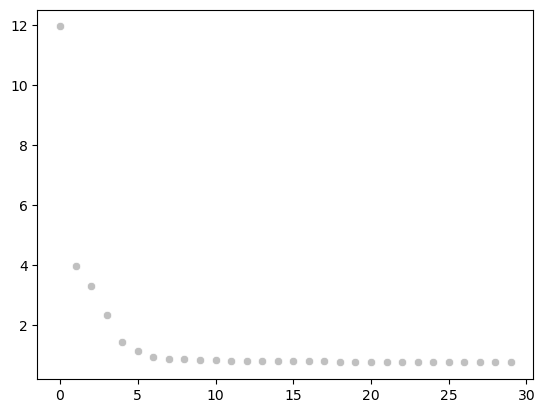

In [51]:
## Studying the dominant atac PC's

U1_init_bn, S1_init_bn, V1_init_bn = np.linalg.svd(B, full_matrices = False)
plot_svd = S1_init_bn[:30]
sns.scatterplot(data = plot_svd) 

In [ ]:
## Correcting for the noise variance

k_B = 10
n_features_B = B.shape[1]
n_samples_B = B.shape[0]
B_residual = B-U1_init_bn[:,:k_B] @ np.diag(S1_init_bn[:k_B]) @ V1_init_bn[:k_B,:]
tau_sq_correct_B = np.sum(B_residual**2) / n_features_B 

<Axes: >

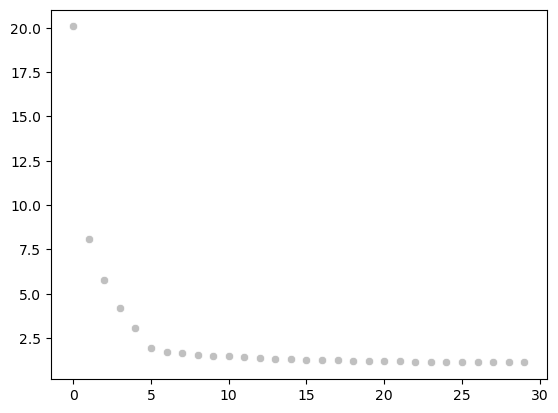

In [53]:
## Studying the dominant rna PC's

U2_init_bn, S2_init_bn, V2_init_bn = np.linalg.svd(C, full_matrices = False)
plot_svd = S2_init_bn[:30]
sns.scatterplot(data = plot_svd) 

In [ ]:
## Correcting for the noise variance

k_C = 15
n_features_C = C.shape[1]
n_samples_C = C.shape[0]
C_residual = C-U2_init_bn[:,:k_C] @ np.diag(S2_init_bn[:k_C]) @ V2_init_bn[:k_C,:]
tau_sq_correct_C = np.sum(C_residual**2) / n_features_C 

In [55]:
A_reduced = A
B_reduced = B / np.sqrt(tau_sq_correct_B)
C_reduced = C / np.sqrt(tau_sq_correct_C)

In [56]:
# Clean up the meta data

meta = utils.read_csv('cleaned_cell_labels_meta_tea_seq.csv')
meta = pd.DataFrame(meta)
meta = meta.T
meta = meta.to_numpy()
meta = np.delete(meta, obj = 0, axis = 1)
labels = meta.flatten(order='C')

In [57]:
np.random.seed(seed)

### Separate the training and test data

We seggregate 1 CD8 effector, 1 Double negative T cell and 1 pre-B cell to use as test data.

In [58]:
index_holdout_full_set_1 = np.where(labels == 'CD8 effector')
indices_cd8e = np.array(index_holdout_full_set_1)
number_cd8e = indices_cd8e.shape[1]

In [59]:
index_holdout_full_set_2 = np.where(labels == 'Double negative T cell')
indices_dnt = np.array(index_holdout_full_set_2)
number_dnt = indices_dnt.shape[1]

In [60]:
index_holdout_full_set_3 = np.where(labels == 'pre-B cell')
indices_pbc = np.array(index_holdout_full_set_3)
number_pbc = indices_pbc.shape[1]

In [61]:
## Separate training and query data


randomlist_1 = np.random.choice(np.ndarray.flatten(indices_cd8e),1,replace=False)
randomlist_2 = np.random.choice(np.ndarray.flatten(indices_dnt),1,replace=False)
randomlist_3 = np.random.choice(np.ndarray.flatten(indices_pbc),1,replace=False)
ix_holdout = np.array([randomlist_1, randomlist_2, randomlist_3])

ix_holdout = ix_holdout.flatten(order='C')
ix_total = np.array(range(B_reduced.shape[0]))
ix_remain = np.setdiff1d(ix_total, ix_holdout)

In [62]:
## Training Data

A_amp = A_reduced[ix_remain,:]
B_amp = B_reduced[ix_remain,:]
C_amp = C_reduced[ix_remain,:]
A_original = A_reduced
B_original = B_reduced
C_original = C_reduced
A_reduced = A_amp
B_reduced = B_amp
C_reduced = C_amp

In [63]:
## Test Data

A_holdout = A_original[ix_holdout,:]
B_holdout = B_original[ix_holdout,:]
C_holdout = C_original[ix_holdout,:]

Now we can estimate the scaling matrix hatbmL\hat{\bm L} defined in (2.6) of the paper.

In [64]:
## Estimate L

cov_A = (1 / A_amp.shape[0]) * A_amp.T @ A_amp
L_rough = cov_A - np.identity(A_amp.shape[1])
val, vec = np.linalg.eig(L_rough)
diag_adjust = np.diag(np.sqrt(val))
L = vec @ diag_adjust

### Prior Estimation and the Initialization of Algorithm 1

In this section, we define the initializers to the Algorithm 1 and propose a mechanism to estimate the priors.

In [65]:
## Aspect Ratios

gamma_1 = B_reduced.shape[1]/B_reduced.shape[0]
gamma_2 = C_reduced.shape[1]/C_reduced.shape[0]

In [66]:
## Compute Singular Value Decomposition of B

k = 10
k_B = k

U1_init, S1_init, V1_init = np.linalg.svd(B_reduced, full_matrices = False)
s_hat = S1_init[0:k] / np.sqrt(gamma_1)
S_hat = np.diag(s_hat)

sigma_x = (1 + gamma_1 * s_hat ** 2) / (gamma_1 * s_hat ** 2 * (s_hat ** 2 + 1))
mu_x = np.sqrt(1 - sigma_x)
sigmabar_x = (1 + s_hat ** 2) / (s_hat ** 2 * (gamma_1 * s_hat ** 2 + 1))
mubar_x = np.sqrt(1 - sigmabar_x)

# initialize M0 and Q0 for X

M_0_x = np.diag(mu_x)
Sigma_0_x = np.diag(sigma_x)
M_bar_x = np.diag(mubar_x)
Sigma_bar_x = np.diag(sigmabar_x)

In [67]:
## Compute Singular Value Decomposition of C

k_2 = 15
k_C = k_2

U2_init, S2_init, V2_init = np.linalg.svd(C_reduced, full_matrices = False)
s_tilde = S2_init[0:k_2] / np.sqrt(gamma_2)
S_tilde = np.diag(s_tilde)

sigma_y = (1 + gamma_2 * s_tilde ** 2) / (gamma_2 * s_tilde ** 2 * (s_tilde ** 2 + 1))
mu_y = np.sqrt(1 - sigma_y)
sigmabar_y = (1 + s_tilde ** 2) / (s_tilde ** 2 * (gamma_2 * s_tilde ** 2 + 1))
mubar_y = np.sqrt(1 - sigmabar_y)

# initialize M0 and Q0 for Y

M_0_y = np.diag(mu_y)
Sigma_0_y = np.diag(sigma_y)
M_bar_y = np.diag(mubar_y)
Sigma_bar_y = np.diag(sigmabar_y)

In [68]:
n = B_reduced.shape[0]; p_1 = B_reduced.shape[1]; p_2 = C_reduced.shape[1]

In [69]:
## Scaling of the singular vectors of B and C

F_x = np.sqrt(n) * U1_init[:,:k]
G_x = np.sqrt(p_1) * V1_init.T[:,:k]

F_y = np.sqrt(n) * U2_init[:,:k_2]
G_y = np.sqrt(p_2) * V2_init.T[:,:k_2]

G = G_x
U_x_t = F_x @ sp.linalg.sqrtm(Sigma_0_x)

Gbar = G_y
U_y_t = F_y @ sp.linalg.sqrtm(Sigma_0_y)

In [70]:
# Initializer of the Protein component embeddings

F_z = A_reduced
U_z_t = F_z @ np.linalg.inv(L)

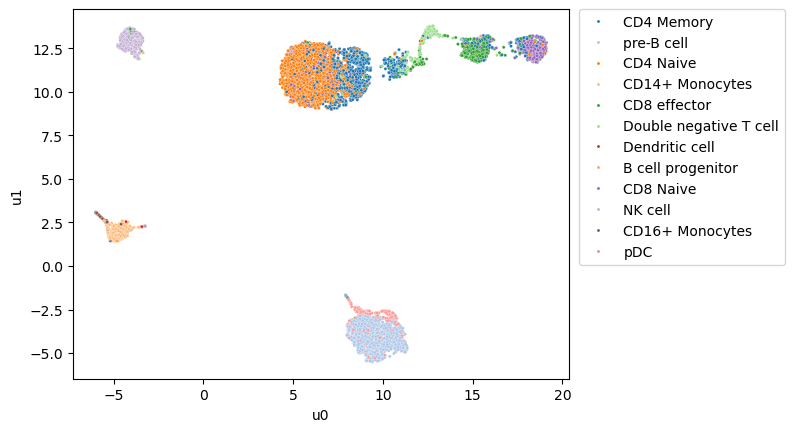

In [71]:
## Visulize UMAP without Data Integration

joint_embedding_PC = np.concatenate((U_z_t,U_x_t,U_y_t),axis=1)
u_pc_embedding = umap.UMAP().fit_transform(
        joint_embedding_PC )
umap_data_PC = pd.DataFrame({'u0': u_pc_embedding[:, 0], 'u1': u_pc_embedding[:, 1], 'label': labels[ix_remain]})
sns.scatterplot(data=umap_data_PC, x='u0', y='u1', hue='label', palette= 'tab20', s = 5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

In [72]:
## Determine the support for GMM prior estimation

Sigma_bar_z = np.eye(L.shape[0])

n_clusters_u = int(np.round(np.cbrt(n)))
n_clusters_v_1 = int(np.round(np.cbrt(p_1)))
n_clusters_v_2 = int(np.round(np.cbrt(p_2)))

data_prior_u = np.concatenate((F_x,F_y,F_z), axis=1)
means_prior_u = sp.linalg.block_diag(M_bar_x, M_bar_y, L)
cov_prior_u = sp.linalg.block_diag(Sigma_bar_x, Sigma_bar_y, Sigma_bar_z)

data_prior_v_x = G_x
means_prior_v_x = M_0_x
cov_prior_v_x = Sigma_0_x

data_prior_v_y = G_y
means_prior_v_y = M_0_y
cov_prior_v_y = Sigma_0_y


In [ ]:
## NPMLE of the priors of right singular vectors

mean_prior_comp_v_x, cov_prior_comp_v_x, weights_prior_comp_v_x = fit_gmm(data_prior_v_x, n_clusters_v_1, means_prior_v_x, cov_prior_v_x, seed)
mean_prior_comp_v_y, cov_prior_comp_v_y, weights_prior_comp_v_y = fit_gmm(data_prior_v_y, n_clusters_v_2, means_prior_v_y, cov_prior_v_y, seed)

In [74]:
## NPMLE of the priors of left singular vectors
mean_prior_comp_u, cov_prior_comp_u, weights_prior_comp_u = fit_gmm(data_prior_u, n_clusters_u, means_prior_u, cov_prior_u, seed)

###  OrchAMP based atlas building

The code below builds OrchAMP atlas from training data.

In [75]:
# iterative refinement

max_iter = 15

M_x = np.array([M_0_x])
M_y = np.array([M_0_y])
Sigma_x = np.array([Sigma_0_x])
Sigma_y = np.array([Sigma_0_y])

for t in range(max_iter):
    
    # Denoising the right singular vectors
    
    V_x_t = denoise_gmm(G, mean_prior_comp_v_x, cov_prior_comp_v_x, M_x, Sigma_x, weights_prior_comp_v_x)
    V_y_t = denoise_gmm(Gbar, mean_prior_comp_v_y, cov_prior_comp_v_y, M_y, Sigma_y, weights_prior_comp_v_y)
    
    # Compute the Jacobians
    J_x = np.mean(ddenoise_gmm(G, mean_prior_comp_v_x, cov_prior_comp_v_x, M_x, Sigma_x, weights_prior_comp_v_x), axis=0)
    J_y = np.mean(ddenoise_gmm(Gbar, mean_prior_comp_v_y, cov_prior_comp_v_y, M_y, Sigma_y, weights_prior_comp_v_y), axis=0)
    
    # Substract the onsager terms
    F = B_reduced.dot(V_x_t) - gamma_1 * U_x_t.dot(J_x.T)
    Fbar = C_reduced.dot(V_y_t) - gamma_2 * U_y_t.dot(J_y.T)
    
    # Update State Evolution Parameters
    Sigmabar_x = (V_x_t.T @ V_x_t) / n
    if np.linalg.det(Sigmabar_x) <= 2.7e-05:
        np.fill_diagonal(Sigmabar_x, Sigmabar_x.diagonal() + np.finfo('float32').eps)
    Mbar_x = Sigmabar_x * s_hat
    Sigmabar_y = (V_y_t.T @ V_y_t) / n
    if np.linalg.det(Sigmabar_y) <= 2.7e-05:
        np.fill_diagonal(Sigmabar_y, Sigmabar_y.diagonal() + np.finfo('float32').eps)
    Mbar_y = Sigmabar_y * s_tilde

    Mbar = np.array([Mbar_x, Mbar_y, L], dtype='object')
    Sigmabar = np.array([Sigmabar_x, Sigmabar_y, Sigma_bar_z], dtype='object')
    F_comb = np.concatenate((F, Fbar, F_z), axis=1)

    # Denoise left singular vectors in a orchestrated manner
    U_x_t = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)[:,:k]
    U_y_t = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)[:,k:(k+k_2)]
    U_z_t = denoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)[:,(k+k_2):]
    
    J_comb = ddenoise_gmm(F_comb, mean_prior_comp_u, cov_prior_comp_u, Mbar, Sigmabar, weights_prior_comp_u)
    
    # Compute the Jacobians
    J_1 = np.mean(J_comb[:,:k,:k], axis = 0)
    J_2 = np.mean(J_comb[:,k:(k+k_2),k:(k+k_2)], axis = 0)
    
    # Substract the onsager terms
    G = (B_reduced.T).dot(U_x_t) - V_x_t.dot(J_1.T)
    Gbar = (C_reduced.T).dot(U_y_t) - V_y_t.dot(J_2.T)
    
    # Update State Evolution Parameters
    Sigma_x = (U_x_t.T @ U_x_t) / n
    if np.linalg.det(Sigma_x) <= 2.7e-05:
        np.fill_diagonal(Sigma_x, Sigma_x.diagonal() + np.finfo('float32').eps)
    M_x = Sigma_x * s_hat
    Sigma_y = (U_y_t.T @ U_y_t) / n
    if np.linalg.det(Sigma_y) <= 2.7e-05:
        np.fill_diagonal(Sigma_y, Sigma_y.diagonal() + np.finfo('float32').eps)
    M_y = Sigma_y * s_tilde

    M_x = np.array([M_x])
    M_y = np.array([M_y])
    Sigma_x = np.array([Sigma_x])
    Sigma_y = np.array([Sigma_y])
    
    print(f"The current iteration is {t}")
   
    ## Update the priors and the support if needed

    ### pi_single_v_x = estimate_prior_single(G, supp_x_v, M_x, Sigma_x, 10)
    ### pi_single_v_y = estimate_prior_single(Gbar, supp_y_v, M_y, Sigma_y, 10)
    ### pi_joint_u = estimate_prior_joint(F, Fbar, supp_x_u, supp_y_u, Mbar_x, Mbar_y, Sigmabar_x, Sigmabar_y, 10)
    ### supp_x_u = extract_support(F, n_clusters_u, Mbar_x)
    ### supp_y_u = extract_support(Fbar, n_clusters_u, Mbar_y)

    ### supp_x_v = extract_support(G, n_clusters_u, M_x)
    ### supp_y_v = extract_support(Gbar, n_clusters_u, M_y)

The current iteration is 0
The current iteration is 1
The current iteration is 2
The current iteration is 3
The current iteration is 4
The current iteration is 5
The current iteration is 6
The current iteration is 7
The current iteration is 8
The current iteration is 9
The current iteration is 10
The current iteration is 11
The current iteration is 12
The current iteration is 13
The current iteration is 14


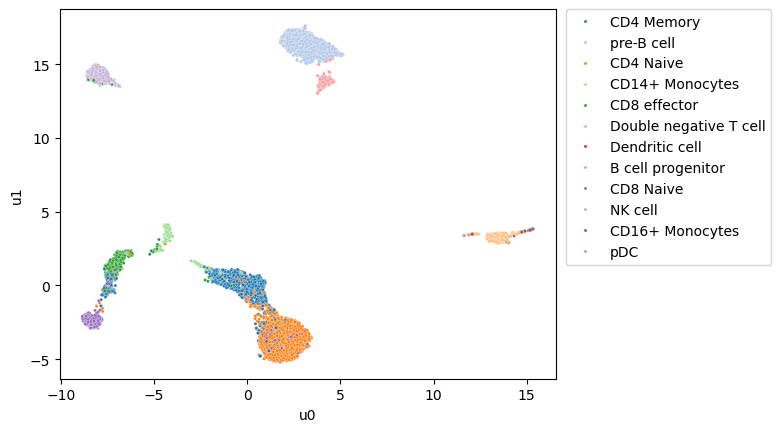

In [76]:
joint_embedding_amp = np.concatenate((U_z_t,U_x_t,U_y_t),axis=1)
amp_for_pred = pd.DataFrame(joint_embedding_amp)
amp_for_pred.to_csv('amp_for_prediction.csv')
u_joint_embedding = umap.UMAP().fit_transform(
        joint_embedding_amp)
umap_data = pd.DataFrame({'u0': u_joint_embedding[:, 0], 'u1': u_joint_embedding[:, 1], 'label': labels[ix_remain]})
sns.scatterplot(data=umap_data, x='u0', y='u1', hue='label', palette= 'tab20', s = 5)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0)

### Refitting the prior with the atlas embeddings for better prediction

In [77]:
## Specify a list of number of components to refit the GMM

components_list = np.array(range(n_clusters_u))+2

In [78]:
## Refitting the GMM with AMP embeddings

gmm_predict = fit_gmm_post(joint_embedding_amp, components_list, seed)
means_joint = gmm_predict.means_
cov_joint = gmm_predict.covariances_
weights_joint = gmm_predict.weights_
labels_modified = labels[ix_remain]


### Predicting with full set of proteins

In this section we compute the point prediction and prediction set of an pre-B cell using only protein modality

In [79]:
## Computation of reference mean and covariances for point prediction

index = range(k_A)
left_index = np.setdiff1d(range(k_A+k_B+k_C),index)
M_pred_0 = np.array([np.hstack((L, np.zeros((k_A, k_B)), np.zeros((k_A, k_C))))])
Sigma_pred_0 = np.array([np.eye(k_A)])
num_components = len(weights_joint)

In [80]:
## Computation of joint mean and covariances for reference and query for point prediction

M_pred_1 = np.hstack((L, np.zeros((k_A, k_B)), np.zeros((k_A, k_C))))
Sigma_pred_1 = np.eye(k_A)
m_prior_known = means_joint @ M_pred_1.T
m_prior_unknown = means_joint
cov_prior_comp_known = np.array([M_pred_1 @ cov_matrix @ M_pred_1.T + Sigma_pred_1 for cov_matrix in cov_joint])
cov_prior_comp_unknown = np.array([cov_matrix for cov_matrix in cov_joint])
cross_cov_unknown_known = np.array([cov_matrix @ M_pred_1.T for cov_matrix in cov_joint])


In [81]:
## Computation of conditional distribution and point prediction (hat_pred)

alpha = 95

index_1_pred = 2
n_samples_pi = 500
means_cond, cov_cond = predict_gmm_distr(A_holdout[index_1_pred,:], m_prior_known, m_prior_unknown, cov_prior_comp_known, cov_prior_comp_unknown, cross_cov_unknown_known)
weights_pred = _get_W_gmm(A_holdout, means_joint, cov_joint, M_pred_0, Sigma_pred_0, weights_joint)[index_1_pred,:]
hat_pred = np.average(means_cond, axis=0, weights=weights_pred)

In [82]:
# Create a Gaussian Mixture Model which is the posterior
gmm_temp = GaussianMixture(n_components=len(cov_cond), covariance_type='full')

# Set means, covariances, and weights
gmm_temp.means_ = means_cond
gmm_temp.covariances_ = cov_cond
gmm_temp.weights_ = weights_pred

num_samples = 10000  # Adjust the number of samples as needed
samples_A_cond, _ = gmm_temp.sample(num_samples)
samples_A_cond = samples_A_cond
samples_A_cond = samples_A_cond - hat_pred
radius_large_sample = np.linalg.norm(samples_A_cond, axis=1)
radius_cond_prot_pred = np.percentile(radius_large_sample,alpha) 


In [83]:
## Approximation of b_alpha: radius of prediction set (by sampling)

u_1_cond_mono_1 = np.random.randn(k_B+k_C+k_A,500) 
u_1_cond_mono_1 /= np.linalg.norm(u_1_cond_mono_1, axis=0)
u_1_cond_mono_1 = u_1_cond_mono_1.T
r_1_cond_mono_1 = np.random.uniform(0,radius_cond_prot_pred,500)    
pred_noise_unobserved = r_1_cond_mono_1[:,np.newaxis] * u_1_cond_mono_1
predicted_embedding = np.array(hat_pred + pred_noise_unobserved)
   

In [ ]:
ixpred_full, dxpred_full = pairwise_distances_argmin_min(predicted_embedding,joint_embedding_amp)
labels_projected_test_full = labels_modified[ixpred_full]
labels_projected_test_full


### Storing the predicted embeddings

In this section, we store the predicted embeddings, the labels of the training cells and the projected labels of the test set (the label of their nearest neighbor in the training data)

In [86]:
predicted_embeddings_set = pd.DataFrame(predicted_embedding)
predicted_embeddings_set.to_csv('predicted_embeddings_set_full_set_prot.csv')

labels_modified_store = pd.DataFrame(labels_modified)
labels_modified_store.to_csv('labels_modified_pred_full_set_prot.csv')

labels_projected_test_full_store = pd.DataFrame(labels_projected_test_full)
labels_projected_test_full_store.to_csv('labels_projected_test_full_store_full_set_prot.csv')




### Predicting with full set of RNA

Other parts of the code are same as that in protein

In [87]:
# Computation of R_hat described in paper

hat_R = (1/n) * np.diag(s_tilde) @ V_y_t.T
tilde_U = C_holdout @ hat_R.T @ np.linalg.inv(hat_R @ hat_R.T)
tilde_U_embedding = tilde_U 

D_2 = np.diag(s_tilde)
matrix_adjustment_sigma_C = D_2 @ Sigmabar_y @ D_2
matrix_adjustment_sigma_C = sp.linalg.sqrtm(matrix_adjustment_sigma_C)
matrix_adjustment_sigma_C = np.linalg.inv(matrix_adjustment_sigma_C)

mean_mat_C = np.identity(matrix_adjustment_sigma_C.shape[1])

In [88]:
# Computation of reference mean and covariances for point prediction

index = range(k_C)
left_index = np.setdiff1d(range(k_B+k_C),index)
M_pred_0 = np.array([np.hstack((np.zeros((k_C, k_A)), np.zeros((k_C, k_B)), mean_mat_C))])
Sigma_pred_0 = np.array([matrix_adjustment_sigma_C])
num_components = len(weights_joint)

In [89]:
# Computation of joint mean and covariances for reference and query for point prediction

M_pred_1 = np.hstack((np.zeros((k_C, k_A)), np.zeros((k_C, k_B)), mean_mat_C))
Sigma_pred_1 = matrix_adjustment_sigma_C
m_prior_known = means_joint @ M_pred_1.T
m_prior_unknown = means_joint
cov_prior_comp_known = np.array([M_pred_1 @ cov_matrix @ M_pred_1.T + Sigma_pred_1 for cov_matrix in cov_joint])
cov_prior_comp_unknown = np.array([cov_matrix for cov_matrix in cov_joint])
cross_cov_unknown_known = np.array([cov_matrix @ M_pred_1.T for cov_matrix in cov_joint])


In [90]:
# Computation of point predictor

alpha = 95
index_1_pred = 1
n_samples_pi = 500
means_cond, cov_cond = predict_gmm_distr(tilde_U_embedding[index_1_pred,:], m_prior_known, m_prior_unknown, cov_prior_comp_known, cov_prior_comp_unknown, cross_cov_unknown_known)
weights_pred = _get_W_gmm(tilde_U_embedding, means_joint, cov_joint, M_pred_0, Sigma_pred_0, weights_joint)[index_1_pred,:]
hat_pred = np.average(means_cond, axis=0, weights=weights_pred)

In [91]:
# Create a Gaussian Mixture Model
gmm_temp = GaussianMixture(n_components=len(cov_cond), covariance_type='full')

# Set means, covariances, and weights
gmm_temp.means_ = means_cond
gmm_temp.covariances_ = cov_cond
gmm_temp.weights_ = weights_pred

num_samples = 10000  # Adjust the number of samples as needed
samples_A_cond, _ = gmm_temp.sample(num_samples)
samples_A_cond = samples_A_cond
samples_A_cond = samples_A_cond - hat_pred
radius_large_sample = np.linalg.norm(samples_A_cond, axis=1)
radius_cond_prot_pred = np.percentile(radius_large_sample,alpha) 


In [92]:
# Computation of radius of prediction set

u_1_cond_mono_1 = np.random.randn(k_B+k_C+k_A,500) 
u_1_cond_mono_1 /= np.linalg.norm(u_1_cond_mono_1, axis=0)
u_1_cond_mono_1 = u_1_cond_mono_1.T
r_1_cond_mono_1 = np.random.uniform(0,radius_cond_prot_pred,500)    
pred_noise_unobserved = r_1_cond_mono_1[:,np.newaxis] * u_1_cond_mono_1
predicted_embedding = np.array(hat_pred + pred_noise_unobserved)
   

In [ ]:
ixpred_full, dxpred_full = pairwise_distances_argmin_min(predicted_embedding,joint_embedding_amp)
labels_projected_test_full = labels_modified[ixpred_full]
labels_projected_test_full

In [94]:
predicted_embeddings_set = pd.DataFrame(predicted_embedding)
predicted_embeddings_set.to_csv('predicted_embeddings_set_full_set_rna.csv')

labels_modified_store = pd.DataFrame(labels_modified)
labels_modified_store.to_csv('labels_modified_pred_full_set_rna.csv')

labels_projected_test_full_store = pd.DataFrame(labels_projected_test_full)
labels_projected_test_full_store.to_csv('labels_projected_test_full_store_full_set_rna.csv')


###  Prediction with full set of ATAC

In [96]:
hat_R = (1/n) * np.diag(s_hat) @ V_x_t.T
tilde_U = B_holdout @ hat_R.T @ np.linalg.inv(hat_R @ hat_R.T)
tilde_U_embedding = tilde_U 

D_2 = np.diag(s_hat)
matrix_adjustment_sigma_C = D_2 @ Sigmabar_x @ D_2
matrix_adjustment_sigma_C = sp.linalg.sqrtm(matrix_adjustment_sigma_C)
matrix_adjustment_sigma_C = np.linalg.inv(matrix_adjustment_sigma_C)

mean_mat_C = np.identity(matrix_adjustment_sigma_C.shape[1])

In [97]:
index = range(k_C)
left_index = np.setdiff1d(range(k_B+k_C),index)
M_pred_0 = np.array([np.hstack((np.zeros((k_B, k_A)), mean_mat_C, np.zeros((k_B, k_C))))])
Sigma_pred_0 = np.array([matrix_adjustment_sigma_C])
num_components = len(weights_joint)

In [98]:
M_pred_1 = np.hstack((np.zeros((k_B, k_A)), mean_mat_C, np.zeros((k_B, k_C))))
Sigma_pred_1 = matrix_adjustment_sigma_C
m_prior_known = means_joint @ M_pred_1.T
m_prior_unknown = means_joint
cov_prior_comp_known = np.array([M_pred_1 @ cov_matrix @ M_pred_1.T + Sigma_pred_1 for cov_matrix in cov_joint])
cov_prior_comp_unknown = np.array([cov_matrix for cov_matrix in cov_joint])
cross_cov_unknown_known = np.array([cov_matrix @ M_pred_1.T for cov_matrix in cov_joint])


In [99]:
alpha = 95
index_1_pred = 0
n_samples_pi = 500
means_cond, cov_cond = predict_gmm_distr(tilde_U_embedding[index_1_pred,:], m_prior_known, m_prior_unknown, cov_prior_comp_known, cov_prior_comp_unknown, cross_cov_unknown_known)
weights_pred = _get_W_gmm(tilde_U_embedding, means_joint, cov_joint, M_pred_0, Sigma_pred_0, weights_joint)[index_1_pred,:]
hat_pred = np.average(means_cond, axis=0, weights=weights_pred)

In [100]:
# Create a Gaussian Mixture Model
gmm_temp = GaussianMixture(n_components=len(cov_cond), covariance_type='full')

# Set means, covariances, and weights
gmm_temp.means_ = means_cond
gmm_temp.covariances_ = cov_cond
gmm_temp.weights_ = weights_pred

num_samples = 10000  # Adjust the number of samples as needed
samples_A_cond, _ = gmm_temp.sample(num_samples)
samples_A_cond = samples_A_cond
samples_A_cond = samples_A_cond - hat_pred
radius_large_sample = np.linalg.norm(samples_A_cond, axis=1)
radius_cond_prot_pred = np.percentile(radius_large_sample,alpha) 


In [101]:
u_1_cond_mono_1 = np.random.randn(k_B+k_C+k_A,500) 
u_1_cond_mono_1 /= np.linalg.norm(u_1_cond_mono_1, axis=0)
u_1_cond_mono_1 = u_1_cond_mono_1.T
r_1_cond_mono_1 = np.random.uniform(0,radius_cond_prot_pred,500)    
pred_noise_unobserved = r_1_cond_mono_1[:,np.newaxis] * u_1_cond_mono_1
predicted_embedding = np.array(hat_pred + pred_noise_unobserved)
   

In [ ]:
ixpred_full, dxpred_full = pairwise_distances_argmin_min(predicted_embedding,joint_embedding_amp)
labels_projected_test_full = labels_modified[ixpred_full]
labels_projected_test_full

In [104]:
predicted_embeddings_set = pd.DataFrame(predicted_embedding)
predicted_embeddings_set.to_csv('predicted_embeddings_set_full_set_atac.csv')

labels_modified_store = pd.DataFrame(labels_modified)
labels_modified_store.to_csv('labels_modified_pred_full_set_atac.csv')

labels_projected_test_full_store = pd.DataFrame(labels_projected_test_full)
labels_projected_test_full_store.to_csv('labels_projected_test_full_store_full_set_atac.csv')
